In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')
import numpy as np
import networkqit as nq
import networkx as nx
import seaborn as sns
import numdifftools as nd
from numpy.random import random as rand
from networkqit import graph_laplacian as GL
from scipy.linalg import eigvalsh
from scipy.special import logsumexp
import matplotlib.pyplot as plt
sns.set(font_scale=1.75)

In [113]:
def ER(n,p):
    T=np.triu(rand([n,n]),1)
    T=T+T.T
    A=(T<p).astype(float)
    np.fill_diagonal(A,0)
    return A

def LER(n,p):
    return GL(ER(n,p))

Text(0.5,1,'N=500  #samples=1 $\\beta=$0.1')

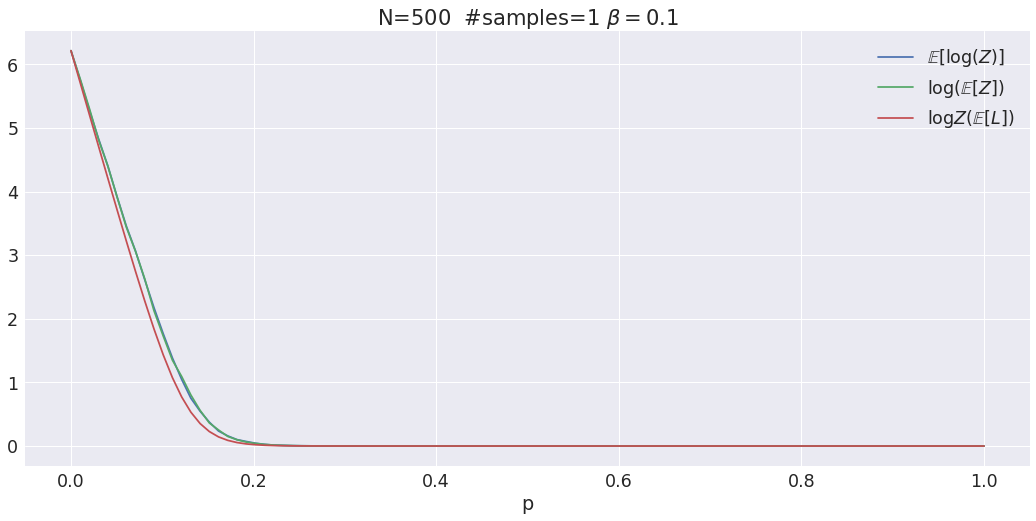

In [9]:
def quenched_average(n,p,beta,reps):
    elogz=0
    for i in range(0,reps):
        elogz += logsumexp(-beta*eigvalsh(LER(n,p)))
    return elogz/reps

def annealed_average(n,p,beta,reps):
    ez=0
    for i in range(0,reps):
        ez += np.exp(-beta*eigvalsh(LER(n,p))).sum()
    return np.log(ez / reps)

def annealed_average_laplacian(n,p,beta):
    return np.log(np.exp(-beta*eigvalsh(GL((1-np.eye(n))*p))).sum())


plt.figure(figsize=(18,8))

beta=0.1
N=500
reps=1

elogz = [quenched_average(N,p,beta,reps) for p in np.linspace(0,1,100)]
logez = [annealed_average(N,p,beta,reps) for p in np.linspace(0,1,100)]
logzl = [annealed_average_laplacian(N,p,beta) for p in np.linspace(0,1,100)]
plt.plot(np.linspace(0,1,100),elogz)
plt.plot(np.linspace(0,1,100),logez)
plt.plot(np.linspace(0,1,100),logzl)
plt.xlabel('p')
plt.legend(['$\\mathbb{E}[\\log(Z)]$','$\\log (\mathbb{E}[Z])$','$\log Z(\\mathbb{E}[L])$'])
plt.title('N='+str(N)+'  #samples='+str(reps)+' $\\beta=$'+str(beta))

In [ ]:
plt.figure(figsize=(18,8))

beta=0.01
N=200
reps=1

elogz = [quenched_average(N,p,beta,reps) for p in np.linspace(0,1,100)]
logez = [annealed_average(N,p,beta,reps) for p in np.linspace(0,1,100)]
logzl = [annealed_average_laplacian(N,p,beta) for p in np.linspace(0,1,100)]
plt.plot(np.linspace(0,1,100),elogz)
plt.plot(np.linspace(0,1,100),logez)
plt.plot(np.linspace(0,1,100),logzl)
plt.xlabel('p')
plt.legend(['$\\mathbb{E}[\\log(Z)]$','$\\log (\mathbb{E}[Z])$','$\log Z(\\mathbb{E}[L])$'])
plt.title('N='+str(N)+'  #samples='+str(reps)+' $\\beta=$'+str(beta))

In [ ]:
beta=0.1
N=50
reps=100

dquenched = nd.Derivative(lambda x : quenched_average(N,x,beta,reps))
dannealed = nd.Derivative(lambda x : annealed_average(N,x,beta,reps))
daveragelapl = nd.Derivative(lambda x : annealed_average_laplacian(N,x,beta))

dp_quenched = [dquenched(p) for p in np.linspace(0,1,100)]
dp_annealed = [dannealed(p) for p in np.linspace(0,1,100)]
dp_averaged = [daveragelapl(p) for p in np.linspace(0,1,100)]
plt.plot(np.linspace(0,1,100),dp_quenched)
plt.plot(np.linspace(0,1,100),dp_annealed)
plt.plot(np.linspace(0,1,100),dp_averaged)

In [ ]:
N=100
A=ER(N,0.5)
print(nx.density(nx.from_numpy_array(A)))
solver = nq.StochasticGradientDescent(A=A,x0=np.array([0.7,]),beta_range=np.logspace(2,-3,50))
model = nq.ErdosRenyi(N=N)
solver.setup(expected_adj_fun=model, adj_sampling_fun=lambda x: ER(N,x), expected_laplacian_grad=model.expected_laplacian_grad,step_callback=lambda beta,p : print('\r',beta,p,end=''))
sol = solver.run(clip_gradients=None, eta=0.01, num_samples=1,tol=0.5*1E-5)

In [ ]:
N=100
A=ER(N,0.3)
print(nx.density(nx.from_numpy_array(A)))
solver = nq.Adam(A=A,x0=np.array([0.8,]),beta_range=np.logspace(1,-2,20))
model = nq.ErdosRenyi(N=N)
solver.setup(expected_adj_fun=model, adj_sampling_fun=lambda x: ER(N,x), expected_laplacian_grad=model.expected_laplacian_grad,step_callback=lambda beta,p : print('\r',beta,p,end=''))
sol = solver.run(clip_gradients=None,alpha=0.001,num_samples=15,tol=1E-4)

In [ ]:
import pandas as pd
pd.DataFrame(sol).plot(y=['c_er'],x='T',logx=True)
plt.semilogx(1/np.logspace(-2,-3,20),[nx.density(nx.from_numpy_array(A))]*20)

In [11]:
def normalized(x):
    return x/x.sum()

# Get the spectral density $\varrho(\lambda)$ for the Laplacian of the Erdos-Renyi graph

In [180]:
def spectral_density_laplacian_er(n,p,x,reps,eps=1E-1):
    def resolvent_trace(x,lambdai):
        return np.sum([1.0/(xi+1j*eps-x) for xi in lambdai])
    def average_resolvent_trace(x):
        return np.mean([resolvent_trace(x, eigvalsh(LER(n,p)) ) for r in range(0,reps)])
    return [-1/(np.pi*n)*np.imag(average_resolvent_trace(z)) for z in x]

def spectral_density_quantum_vonneumann_er(n,p,x,reps,eps,beta):
    def resolvent_trace(x,lambdai):
        return np.sum([1.0/(xi+1j*eps-x) for xi in lambdai])
    
    def normalized(x):
        return x/x.sum()
    
    def average_resolvent_trace(x):
        return np.mean([resolvent_trace(x, eigvalsh(nq.compute_vonneuman_density(L=LER(n,p),beta=beta)) ) for r in range(0,reps)])
    return [-1/(np.pi*n)*np.imag(average_resolvent_trace(z)) for z in x]

def spectral_density_quantum_vonneumann_er2(n,p,x,reps,eps,beta): # unnormalized version
    def resolvent_trace(x,lambdai):
        return np.sum([1.0/(xi+1j*eps-x) for xi in lambdai])
    
    def normalized(x):
        return x/x.sum()
    
    def average_resolvent_trace(x):
        return np.mean([resolvent_trace(x, np.exp(-beta*eigvalsh(LER(n,p))) ) for r in range(0,reps)])
    return [-1/(np.pi*n)*np.imag(average_resolvent_trace(z)) for z in x]

## Compare the estimate spectra density $\varrho(\lambda)$ with the numerical estimate from the histogram of laplacian eigenvalues

In [65]:
n=50
p=0.8

In [80]:
x=np.linspace(0,60,500)
rho = spectral_density_laplacian_er(n,p,x,100,0.2)

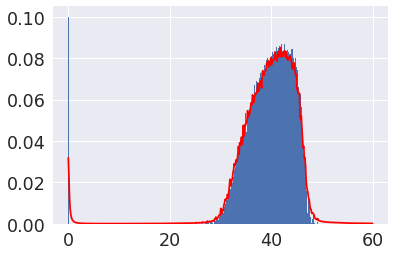

In [81]:
plt.hist(np.array([eigvalsh(LER(n,p)) for r in range(0,1000)]).flatten(),250,density='freq')
plt.plot(x, rho, 'r')
plt.show()

## Compare the spectra of $e^{-\beta L}$ 

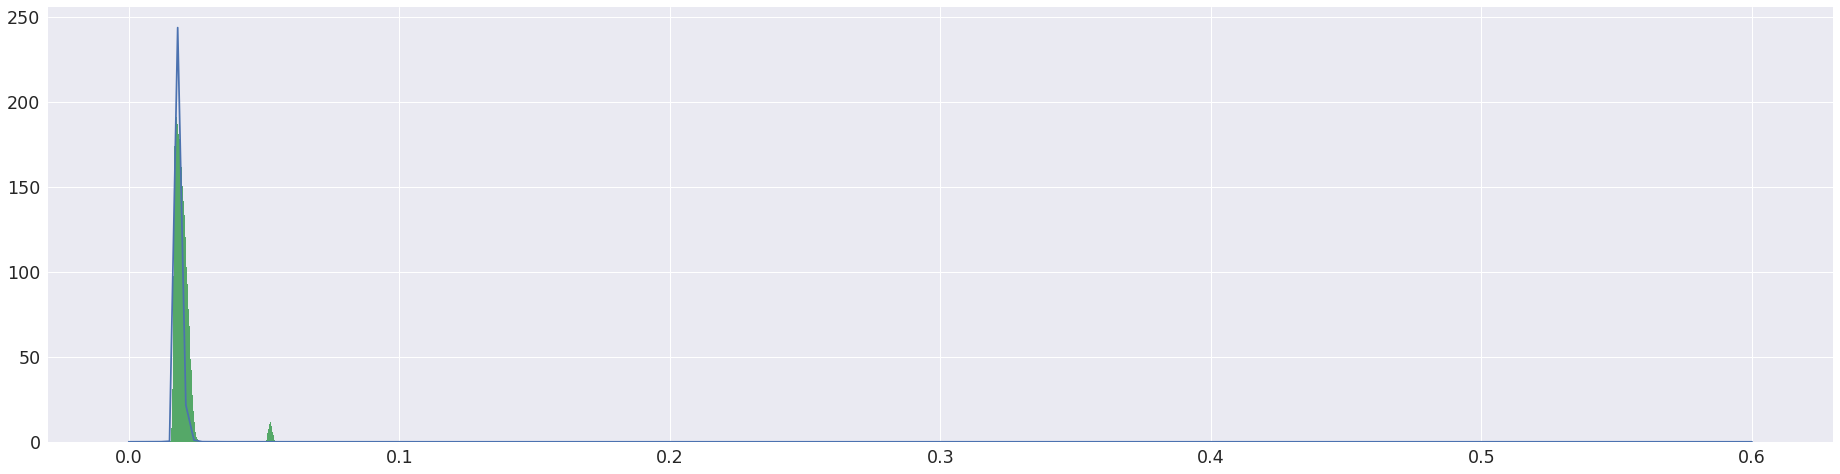

In [178]:
plt.figure(figsize=(32,8))
x = np.linspace(0,0.6,200)
beta = 0.05/2
eps = 1E-5
reps = 5
rho = spectral_density_quantum_vonneumann_er(n,p,x,reps,eps,beta)
plt.plot(x,rho)
plt.hist(np.array([eigvalsh(nq.compute_vonneuman_density(L=LER(n,p),beta=beta)) for r in range(0,1000)]).flatten(),250, density='freq')
#plt.yscale('log')
plt.show()

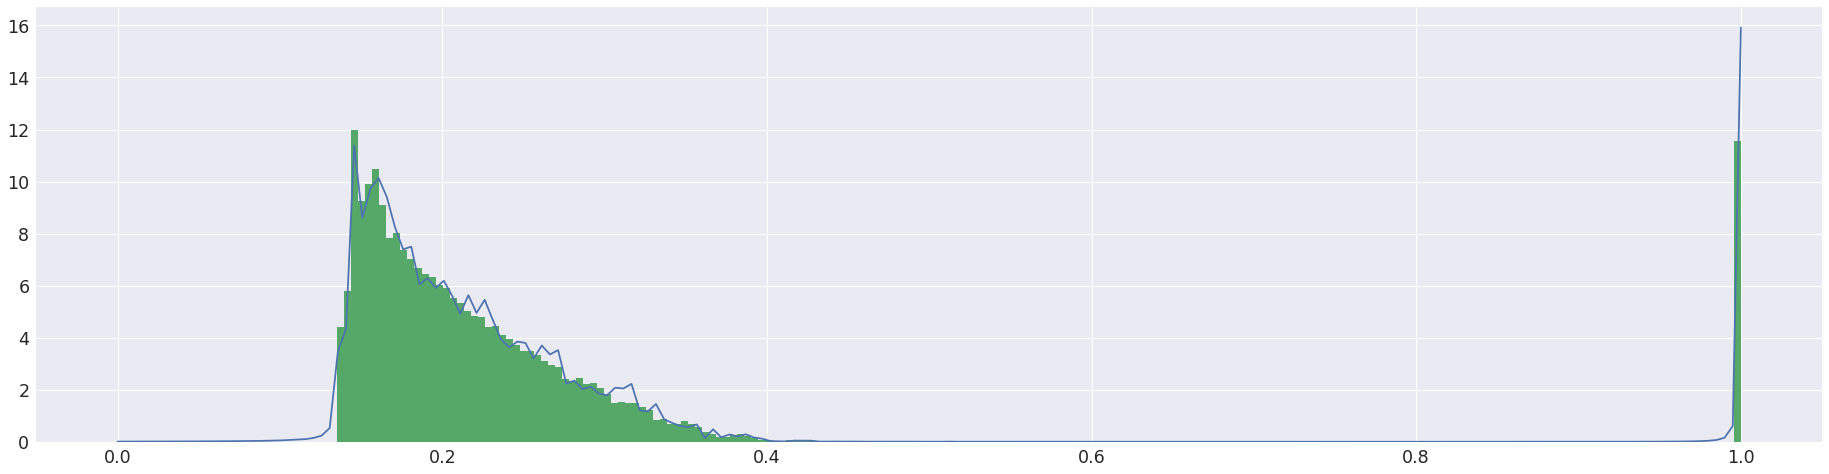

In [205]:
plt.figure(figsize=(32,8))
x = np.linspace(0,1,200)
n=20
p=0.8
beta = 0.1
eps = 1E-3
reps = 100
rho = spectral_density_quantum_vonneumann_er2(n,p,x,reps,eps,beta)
plt.plot(x,rho)
plt.hist(np.array([ np.exp(-beta*eigvalsh(LER(n,p))) for r in range(0,5000)]).flatten(),200, density='freq')
#plt.yscale('log')
plt.show()

## The Laplacian trace $\textrm{Tr}[L]$ can be computed with the integral $n \int \limits_{-\infty}^{+\infty} \lambda \varrho(\lambda) d\lambda$

In [39]:
from scipy.integrate import quad

In [74]:
f = lambda x : x*spectral_density_laplacian_er(n,p,np.array([x]),1,0.1)[0]
trace_laplacian_integral, trace_laplacian_integral_error = quad(f,0,60) # because 60 is the maximum eigenvalue

/usr/local/lib/python3.5/dist-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


In [75]:
trace_laplacian_integral,trace_laplacian_integral_error,np.mean([np.trace(LER(n,p)) for k in range(0,10000)])/n

(39.12557649553721, 0.5022203078475442, 39.194356)

## Compute the derivative of $\varrho$ with respect to the parameters $\theta$

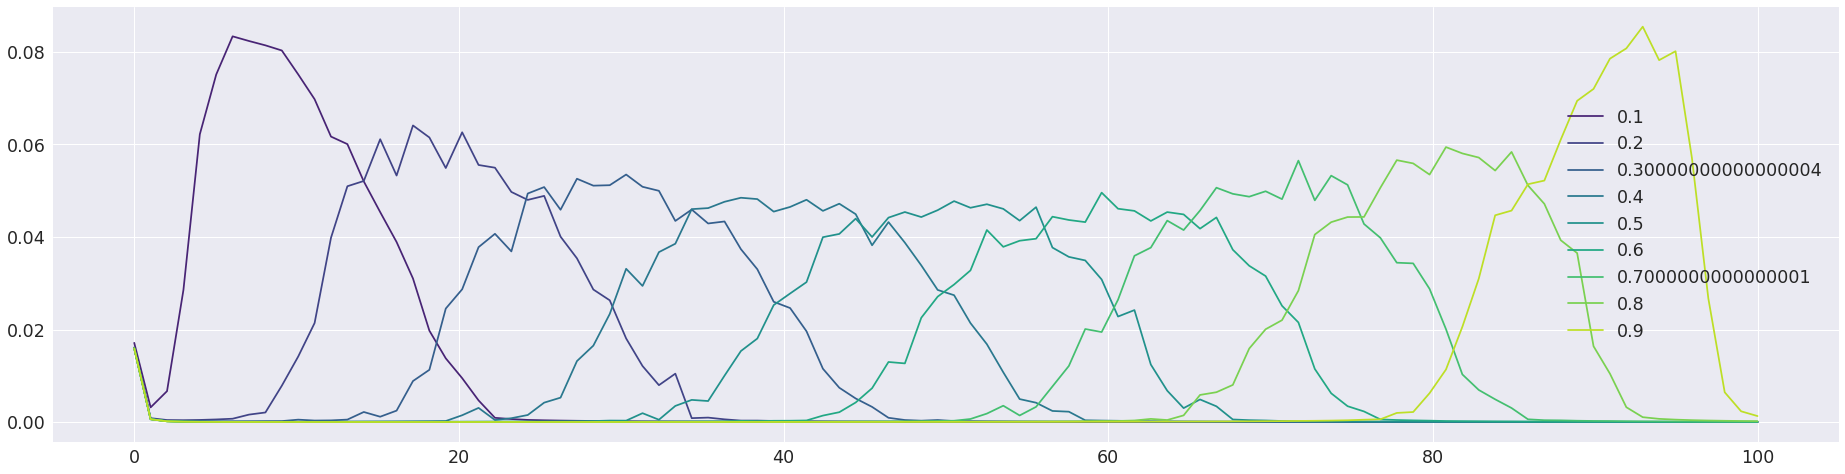

In [228]:
plt.figure(figsize=(32,8))
n=100
reps=10
eps=0.2
z=np.linspace(0,n,100)

f = lambda theta : spectral_density_laplacian_er(n,theta,z,reps,eps)
allp = np.linspace(0.1,0.9,9)
cmap=sns.color_palette('viridis',len(allp))
for i,p in enumerate(allp):
    plt.plot(z,f(p),color=cmap[i])
plt.legend(allp)
plt.show()

In [251]:
plt.figure(figsize=(32,8))
n=100
reps=20
eps=0.5
z=np.linspace(0,n,200)

f = lambda theta,z : spectral_density_laplacian_er(n,theta,np.array([z]),reps,eps)[0]


allp = np.linspace(0.1,0.9,9)
cmap = sns.color_palette('viridis',len(allp))

nd.Gradient(f)(0.5,0.1)
#nd.Gradient(f)(0.5,[0.1])
#for i,p in enumerate(allp):
#    drhodtheta = nd.Derivative(lambda theta : f(theta,z))
#    plt.plot(z,f(p),color=cmap[i])
#plt.legend(allp)
#plt.show()

array(-0.00029174)

<Figure size 2304x576 with 0 Axes>